In [1]:
import climakitae as ck
from climakitae.core.data_interface import get_data
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import warnings
import os
import matplotlib.pyplot as plt

#no warninings outputs for now
warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
STANDARD_CRS = "EPSG:4326" #WGS84
#classic vars
ANALVARS = {"temp": "Air Temperature at 2m","precip": "Precipitation (total)"}
#Just variety of scenarios
SCENARIOS = ["Historical Climate","SSP 3-7.0","SSP 5-8.5", "SSP 2-4.5", "SSP 1-2.6"]
RES = "3 km"
TIMESPAN = (1950, 2100) #similar than for maps, do we not have data for 2100?
BASELINEPER = (1995, 2014)
HISENDYEAR =2014 
SMOOTHINGWindow =10
ourputDataForR = "dataForRScrtips"
os.makedirs(ourputDataForR, exist_ok=True)
print(f"Output directory @:{ourputDataForR}")
#grav Jtree Boundary & Ensure it starts in WGS84
shapefilePath ="../JoshuaTreeOutlines/JoshuaTree/Joshua_Tree_National_Park.shp"
try:
    jTreeBoundary_WGS84 = gpd.read_file(shapefilePath)
    
    #GDP has a CRS and it's  WGS84 initially
    if jTreeBoundary_WGS84.crs is None:
        print("Jtree bounding shape file doesn't have CRS-- Assuming WGS84.")
        jTreeBoundary_WGS84.set_crs(STANDARD_CRS, inplace=True)
    if str(jTreeBoundary_WGS84.crs) != STANDARD_CRS:
        print(f"Reprojecting boundary to {STANDARD_CRS}")
        jTreeBoundary_WGS84 = jTreeBoundary_WGS84.to_crs(STANDARD_CRS)
    bounds =jTreeBoundary_WGS84.total_bounds
    longitudinalSlice =(bounds[0], bounds[2])
    latitidualSlice= (bounds[1], bounds[3])

except Exception as e:
    print(f"couldn't load Jtree bounding file w/ err:{e}")
    print("Making trivial Jtree rectangle instead")
    jTreeBoundary_WGS84 =None
    longitudinalSlice =(-116.6,-115.4)
    latitidualSlice = (33.5, 34.3)


Output directory @:dataForRScrtips
Reprojecting boundary to EPSG:4326


In [2]:
jTreeBoundary = gpd.read_file(shapefilePath)
print("Raw CRS from file:", jTreeBoundary.crs)
print("Raw bounds (minx, miny, maxx, maxy):", jTreeBoundary.total_bounds)

Raw CRS from file: EPSG:4269
Raw bounds (minx, miny, maxx, maxy): [-116.4580428    33.67019079 -115.26220226   34.12934798]


In [ ]:
# Helpers

def convertPrecipUnits(dataArray):
    """
    takes precipitation from 'flux' (kg/m^2/s) to cumulative depth (mm) per month.
    """
    #kg/m^2/s = 1 mm/s
    if dataArray.attrs.get('units') in ['kg/m^2/s', 'kg m-2 s-1']:        
        #dats in month per time stamp
        # nice job. I assume this is taken care of leap years?
        days_in_month = dataArray.time.dt.days_in_month
        seconds_per_day = 86400
        #notes for lab meeting on converstion -> (mm/s) *(seconds/day) * (days/month) = mm/month
        dataArray = (dataArray *seconds_per_day) *days_in_month
        dataArray.attrs['units'] ='mm/month'
        return dataArray
    return dataArray

def maskToBoundary(dataArray,boundaryGDF_WGS84):
    """
    Masks dataarray by reprojecting the Vector boundary to match the RASTER data's CRS, we talked about this in meeting but also 
    seems to fix erros in high-dimen reprojection
    """
    if dataArray is None or boundaryGDF_WGS84 is None:
        return dataArray
    dataCrs = dataArray.rio.crs
    if dataCrs is None:
        print("raster has no CRS can't mask")
        return dataArray
    #Defensively reproject boundary (represented by vector) to match CRS of the raster.
    try:
        if str(dataCrs) != str(boundaryGDF_WGS84.crs):
            print(f"reprojecting boundary vector to match raster CRS ({dataCrs})")
            boundaryNativeCRS =boundaryGDF_WGS84.to_crs(dataCrs)
        else:
            boundaryNativeCRS =boundaryGDF_WGS84
    except Exception as e:
        print(f"Error with reprojecting: {e}.")
        return dataArray

    #Prep data strucutre: cleanup, then transpose for rioxarray compatibilit
    try:
        #need to drop conflicting auxiliary coords which have diff dimens
        coordsToDrop = ['lon','landmask','lakemask'] # Keep 'lat' for weighted avg
        dataCleaned = dataArray.drop_vars(coordsToDrop, errors='ignore')
        #y, x must be last by rioxarray library invariants
        try:
            #find spatial dimens
            spatialDims =(dataCleaned.rio.y_dim, dataCleaned.rio.x_dim)
        except Exception:
             #fallback iff rioxarray attributes are missing
             if 'y' in dataCleaned.dims and 'x' in dataCleaned.dims:
                 spatialDims = ('y','x')
             else:
                print("Error: Could not identify spatial dimensions (x/y).")
                print("couldn't get spatial dimensions -> x & y")
                return dataArray
        nonSpatialDims =[dim for dim in dataCleaned.dims if dim not in spatialDims] #one line filer out all non spatial
        expectedOrder = tuple(nonSpatialDims) +spatialDims
        if dataCleaned.dims != expectedOrder:
            print("  Transposing dimensions")
            dataCleaned =dataCleaned.transpose(*expectedOrder)
    except Exception as e:
        print(f"  Something went wrong in cleaning and transposing: {e}")
        dataCleaned = dataArray

    #Masking == Clipping
    try:
        maskedData= dataCleaned.rio.clip(
            boundaryNativeCRS.geometry.values, 
            drop=False, #Keep dimens, just mask values outside the boundary
            all_touched=True #include partially overlapping pixels
        )
        maskedData.attrs.update(dataArray.attrs)
        return maskedData
        
    except Exception as e:
        print(f"err w/ masking: {e}")
        return dataCleaned

def processVariable(variableKey, variableName, scenarios, resolution, timeSpan, latSlice, longitSice, Boundary_gdf_wgs84):    
    #fetch montly data w/ caladapt API
    print(f"getting monthly {variableKey} data")
    try:
        data = get_data(variable=variableName, resolution=resolution, #just use the consts defined in cell one
            timescale="monthly",scenario=scenarios,
            time_slice=timeSpan,latitude=latSlice,longitude=longitSice)
        if data is None or data.time.size == 0:
            print("  no data got returned")
            return None
    except Exception as e:
        print(f"error in getting {variableKey}: {e}")
        return None

    #Preprocess: Convert Units
    if variableKey =='temp' and data.attrs.get('units') =='K':
        data =data -273.15
        data.attrs['units'] ='°C'        
    if variableKey =='precip':
        data = convertPrecipUnits(data)
    #Spatial Processing (Masking & Averaging)
    maksedData = maskToBoundary(data, Boundary_gdf_wgs84)
    try:
        xDim = maksedData.rio.x_dim
        yDim = maksedData.rio.y_dim
        #  spatial average w/ lat-based weights
        if 'lat' in maksedData.coords:
            # weights with cosine of lat
            weights = np.cos(np.deg2rad(maksedData.lat))
            # weights are masked where data is masked (NaNs)
            weights = weights.where(maksedData.notnull())
            plotWeightsBefore = weights
            if 'simulation' in plotWeightsBefore.dims:
                plotWeightsBefore = plotWeightsBefore.isel(simulation=0, drop=True)
            if 'time' in plotWeightsBefore.dims:
                plotWeightsBefore = plotWeightsBefore.isel(time=0, drop=True)
            plotWeightsBefore.plot()
            plt.title("Weights right before .fillna(0) (NaNs outside park?)")
            plt.show() 



            print(f"    Weights containing NaNs? {np.isnan(weights.values).any()}")
             #post-filter
            weights = weights.fillna(0)
            plotWeightsAfter = weights

            plotWeightsAfter = weights
            if 'simulation' in plotWeightsAfter.dims:
                plotWeightsAfter =plotWeightsAfter.isel(simulation=0, drop=True)
            if 'time' in plotWeightsAfter.dims:
                plotWeightsAfter = plotWeightsAfter.isel(time=0, drop=True)

            plotWeightsAfter.plot()    
            plt.title("weights asfter .fillna(0) (0s outside park)") 
            plt.show() 


            print("  application of latitude-based weights for spatial average.")
            spatialAVG = maksedData.weighted(weights).mean(dim=[xDim, yDim], skipna=True)
        else:
            # Fallback to unweighted mean if 'lat' coordinate is missing
            print("  'using unweighted, still not right")
            spatialAVG = maksedData.mean(dim=[xDim, yDim], skipna=True)
        
    except Exception as e:
        print(f"  err in calculating spatial average: {e}. Trying unweighted mean on original box...")
        try:
            # Fallback to unweighted mean on the unmasked data if weighting failed
            spatialAVG = data.mean(dim=['x','y'], skipna=True)
        except Exception as e2:
            print(f"  Fallback unweighted mean also failed: {e2}. Returning None.")
            return None
    #need to load data into memory for Dask computation argh !
    print("  loading data into memory-- this takes a minutue")
    spatialAVG.load() 
    
    #diagnostic 
    if spatialAVG.isnull().all():
        print("  spatical average is all null")
        return None
    #temporal aggregation annual means/totals
    print("getting annual time series...")
    #need to use 'YE' -- year end for resampling frequency
    if variableKey =='precip':
        #annual total precip (sum of monthly accumulations)
        annualData = spatialAVG.resample(time='YE').sum(dim='time')
        annualData.attrs['units'] ='mm/year'
    else:
        #annual mean temperature (mean of month)
        annualData =spatialAVG.resample(time='YE').mean(dim='time')
    #anomoly calculations
    print(f"getting anomalies relative to baseline")
    #Time based baseline selection
        #we need to get baseline period pruely based on time
        #this handles merged dataset where entire TS might only scare one scenario label
    baselineSlice= annualData.sel(time=slice(str(BASELINEPER[0]), str(BASELINEPER[1])))
    if baselineSlice.time.size ==0:
        print("  No data avalil for the baseline period.")
        return None
    #get mean across the beaseline years for each simulation individually.
    baseline_mean = baselineSlice.mean(dim='time')
    #check baszeline values
    if variableKey =='precip':
        try:
            avg_baseline = baseline_mean.mean().values
            print(f"  precip baseline mean--avg across simulations--: {avg_baseline:.4f} mm/year")
            if np.isnan(avg_baseline) or avg_baseline < 0.1:
                 print("  err: base precipitation is NaN or super super low (< 0.1mm/year).")
        except Exception:
            pass
    #get anomalies-- what's nice though is X array auto aligns dimens like simulation
    if variableKey == 'precip':
       
        anomalies = (annualData -baseline_mean)
        origUnits = annualData.attrs.get('units', 'mm/year')
        unit = f"Δ{origUnits}" 
    else:
        #abs for temperature
        #make sure that temp and precip anomalies have the same unit. (anomalie vs relative anomaly)
        anomalies = (annualData -baseline_mean)
        origUnits =annualData.attrs.get('units','°C')
        unit = f"Δ{origUnits}" #delta here for clipboard
    #genreally as a note mayeb make this more funciton based for different things so i'm not so reliant on prepip 
    #and temp @ 2 meteres TODO ^^
    anomalies.attrs['units'] =unit
    # 6. Smoothing (Decadal Mean)
    #smoothing via decadal mean
    print(f"appling smoothing window on smoothing dinwo (defined in cell one) window average")
    # w/ min_periods=1 to handle maybe missing years well
    smoothed_anomalies =anomalies.rolling(time=SMOOTHINGWindow,center=True, min_periods=1).mean()
    return smoothed_anomalies


getting monthly temp data


<>:64: SyntaxWarning: invalid escape sequence '\C'
<>:66: SyntaxWarning: invalid escape sequence '\c'
<>:64: SyntaxWarning: invalid escape sequence '\C'
<>:66: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_1128/3314204764.py:64: SyntaxWarning: invalid escape sequence '\C'
  print(f"\CSV FOR R is called!: {filename}")
/tmp/ipykernel_1128/3314204764.py:66: SyntaxWarning: invalid escape sequence '\c'
  print("\combiled df empty emptt, nothign saved")


Input scenario='SSP 1-2.6' is not a valid option.
Closest options: 
- SSP 5-8.5
- SSP 3-7.0
- SSP 2-4.5
Outputting data for scenario='SSP 5-8.5'

reprojecting boundary vector to match raster CRS (PROJCS["undefined",GEOGCS["undefined",DATUM["undefined",SPHEROID["undefined",6370000,0]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["standard_parallel_1",30],PARAMETER["standard_parallel_2",60],PARAMETER["latitude_of_origin",38],PARAMETER["central_meridian",-70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]])


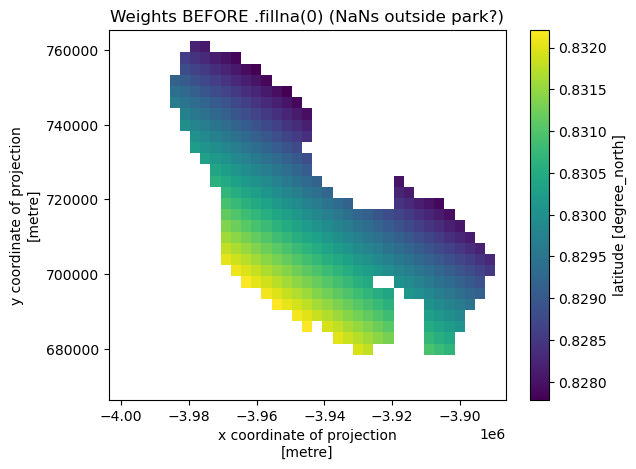

    Weights containing NaNs? True


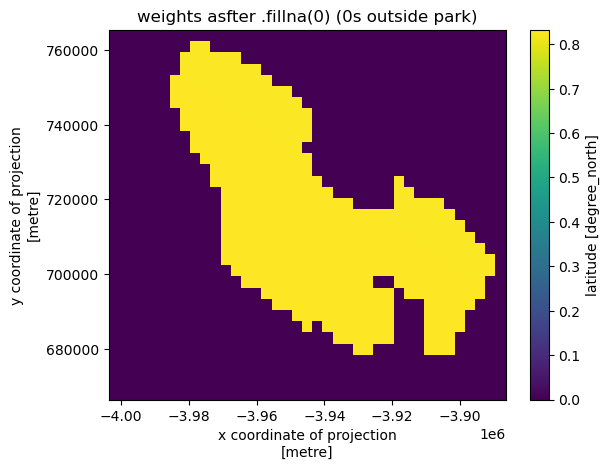

  application of latitude-based weights for spatial average.
  loading data into memory-- this takes a minutue
Calculating annual time series...
getting anomalies relative to baseline
appling smoothing window on smoothing dinwo (defined in cell one) window average
getting monthly precip data
Input scenario='SSP 1-2.6' is not a valid option.
Closest options: 
- SSP 5-8.5
- SSP 3-7.0
- SSP 2-4.5
Outputting data for scenario='SSP 5-8.5'

reprojecting boundary vector to match raster CRS (PROJCS["undefined",GEOGCS["undefined",DATUM["undefined",SPHEROID["undefined",6370000,0]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["standard_parallel_1",30],PARAMETER["standard_parallel_2",60],PARAMETER["latitude_of_origin",38],PARAMETER["central_meridian",-70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]])


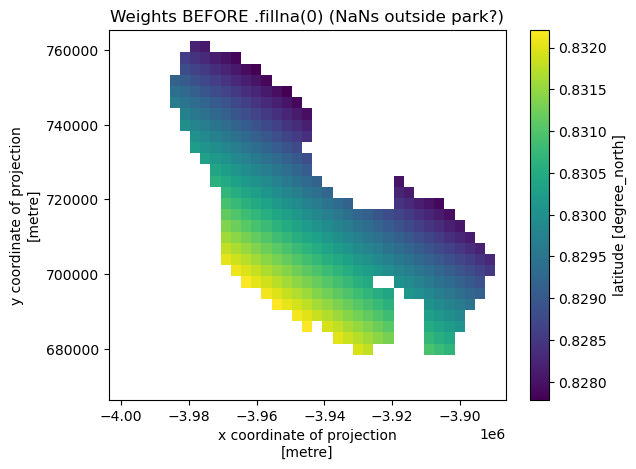

    Weights containing NaNs? True


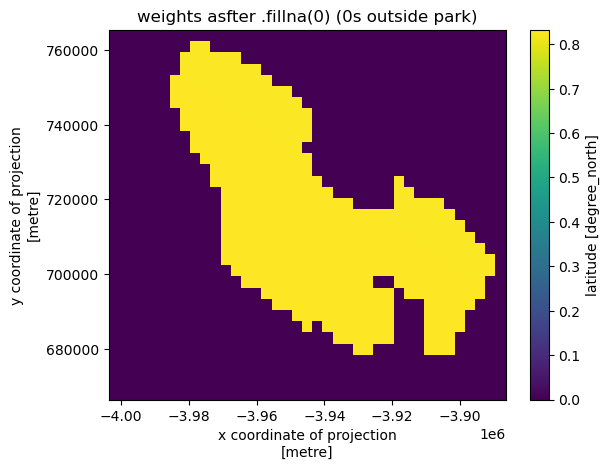

  application of latitude-based weights for spatial average.
  loading data into memory-- this takes a minutue
Calculating annual time series...
getting anomalies relative to baseline
  precip baseline mean--avg across simulations--: 244.1689 mm/year
appling smoothing window on smoothing dinwo (defined in cell one) window average

getting data into csv.
  temp data has 8 sims.
  precip data has 8 sims.
\CSV FOR R is called!: dataForRScrtips/JoshuaTree_decadal_anomalies_combined.csv


In [ ]:
#debugging for my weight debugging 
timeSeriesData ={}
for key, varName in ANALVARS.items():
    #pass the WGS84 boundary GDF to the processing function
    tsData =processVariable(
        key, varName, SCENARIOS, RES, TIMESPAN, latitidualSlice, longitudinalSlice, jTreeBoundary_WGS84)
    if tsData is not None:
        timeSeriesData[key] =tsData
#exporting to csv
if not timeSeriesData:
    print("\no data was processed so exiting.")
else:
    print("\ngetting data into csv.")
    allDFs = []
    for varKey, dataArrat in timeSeriesData.items():
        #converting x array data to pd df
            #there's a helpful func which apparently does this p wel
        df = dataArrat.to_dataframe(name='Anomaly').reset_index()
        #add var name to the column
        df['Variable'] = varKey
        #clean up fs for R tidy format
        if 'time'in df.columns:
            df['Year'] = df['time'].dt.year
            df = df.drop(columns=['time'])
        #post processing now-- standardize scenario names
        #handle merged names like : "Historical + SSP 3-7.0" by relabling based on year
        if 'scenario' in df.columns:
            #clean up raw scenario names, remove historical + prefix iff present
            #ensure they're strings
            stringToRmove = "Historical +"
            sspName =df['scenario'].astype(str).str.replace(stringToRmove, "", regex=False)
            #det final scenario labe based on year
            df['Scenario'] =np.where(
                df['Year']<= HISENDYEAR,
                "Historical Climate", sspName)
            #ensure that standalone historical climate runs iff retrieved separetely are preserved
            #handles cases where ssp_name derived above might already be "Historical Climate" for exampel
            df.loc[df['scenario'] == "Historical Climate", 'Scenario'] ="Historical Climate"
            #clean up orig scenario column
            df = df.drop(columns=['scenario'], errors='ignore')
        if 'simulation' in df.columns:
            df = df.rename(columns={'simulation': 'Simulation'})
        # Two rukles
            #drop Nan/inf vals resulting from rolling windows or anomaly calcs
            #replace Inf/-Inf with NaN first, then drop all NaNs.
        dfCleaned = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['Anomaly'])
        if dfCleaned.empty and not df.empty:
            print(f"  uh oh:all anomaly vals for {varKey} were nan or inf and have been dropped.")
        allDFs.append(dfCleaned)
        #print sims included
        if 'Simulation' in dfCleaned.columns:
            print(f"  {varKey} data has {len(dfCleaned['Simulation'].unique())} sims.")
    if allDFs:
        combinedDf = pd.concat(allDFs)
        if not combinedDf.empty:
            #reorder cols
            try:
                cols =['Year', 'Scenario', 'Simulation', 'Variable', 'Anomaly']
                combinedDf = combinedDf[cols]
            except KeyError:
                print("reordering failed, some columns that were expected weren't there")
            filename = os.path.join(ourputDataForR, "JoshuaTree_decadal_anomalies_combined.csv")
            combinedDf.to_csv(filename, index=False)
            print(f"\CSV FOR R is called!: {filename}")
        else:
            print("\combiled df empty emptt, nothign saved")
    else:
        print("\n no data was generated to save")